In [20]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
from scipy import sparse, signal
import matplotlib.pyplot as plt
from matplotlib import animation
import easygui as eg

In [21]:
params = eg.multenterbox("Enter simulation params",
                         fields=["dt [micro seconds], primary source of runtime for redering animation",
                                 "total time [milli seconds]", "dz [microns], primary source of runtime for solve_ivp"],
                         values=[1, 6, 100])
# Set up simulation params. 
"""Time step size and total time is primary source of runtime for rendering animation"""
dt = float(params[0]) * 1e-6 # time step size, seconds
t0 = 0.0
tf = float(params[1]) * 1e-3 # total time evolution, seconds
t_eval = np.arange(t0, tf, dt)

"""Wire step size is primary source of runtime for solve_ivp"""
dz = float(params[2]) * 1e-6 # wire step size, meters

# Define initial conditions of detector
""" 
Defaults source:
https://www.tribology-abc.com/calculators/properties_of_common_spring_materials.pdf <-- ASTM A228
https://optimumspring.com/technical_resources/materials/carbon_steels/music_wire_228_spring_wire.aspx <-- For mass density 
"""
params = eg.multenterbox("Enter wire params", 
                         fields=["Length [m]", "Mass Density [kg / m^3]", "Tensile strength [MPa]", "Youngs Modulus [GPa]", "Wire Diameter [mm]"],
                         values=[2, 7850, 2751, 207, 4])
l = float(params[0]) # length of wire, meters
rho = float(params[1]) # mass density, kg/m^3
tensile_str = float(params[2]) * 10**6 # Tensile Strength of wire, Pa
young_mod = float(params[3]) * 10**9 # elastic modulus of wire, Pa
dia = float(params[4]) * 10**-3 # diameter of wire, meters
cs_area = np.pi * dia**2 / 4 # cross sectional area of wire, m^2

mu = rho * cs_area # linear mass density, kg/m
tension = 0.1 * tensile_str * cs_area # Tension on wire, N
v_press = np.sqrt(young_mod / rho) # wavespeed for longitudinal wave, m/s
v_shear = np.sqrt(tension / mu) # wavespeed for transverse waves, m/s

wire_props = (f"Length {l:.2e} m || pressure wave speed {v_press:1.2e} m/s || shear wave speed {v_shear:.2e}")
# Impact conditions of particle and track
# TODO: Make 0 custom option
relativistic = (3e8, 1.782e-24) # c [m/s], 1 TeV/c^2 [kg]
thermal_neut = (1919.62, 1.674e-27) # [m/s], [kg] --> T = 298 K, mv^2 = (3/2) k_b T
gal_orbit = (220e3, 1.782e-24) # [m/s], 1 TeV/c^2 [kg]
parts = [None, relativistic, thermal_neut, gal_orbit]
ret = eg.integerbox("Which particle?\n0: Custom\n1: Relativistic DM\n2: Thermal Neutron\n3: Galactic Orbit DM",
                    default=1, lowerbound=0, upperbound=3)
titles = ["Custom", "Relativistic DM", "Thermal Neutron", "Galactic Orbit DM"]
title_label = titles[ret]
if ret == 0:
    custom= eg.multenterbox("Enter custom particle params",
                             fields=["Mass, [kg]", "Speed, [m/s]"],
                             values=[1,1])
    parts[0] = (float(custom[1]), float(custom[0]))
G = 6.67430e-11 # gravitational constant
M = parts[ret][1] # mass of inciting particle, meters/second
v_p = parts[ret][0] # velocity of inciting particle, meters / second


params = eg.multenterbox("Enter impact params", 
                         fields=["z0 (track/wire 'intersection') [m]", "b (dist. of closest approach) [m]", "theta (angle between track and wire) [degrees]", "phi (rot. about wire) [degrees] NOT IMPLEMENTED"],
                         values=[l/4, 0.05, 45, 90])
# TODO: Integrate phi and rotations
z0 = float(params[0]) # position of particle track and wire 'intersection', meters
b = float(params[1]) # shortest distance between wire and particle track, meters
theta = float(params[2]) * (np.pi / 180) # Angle between particle track and z (wire) axes, radians
phi = float(params[3]) * (np.pi / 180) # Angle between particle track and x axes, radians
zwire = np.arange(0 - z0, l - z0, dz) # define wire along z axes s.t. z0 is at z_string == 0

costheta = np.cos(theta)
sintheta = np.sin(theta)
cosphi = np.cos(phi)
sinphi = np.sin(phi)
small = G * M / v_p
v_0 = 2  / ((b**2 + (zwire * sintheta)**2)) # shared component of initial velocities
impact_props = (f"wire 'intersection' {z0:.2e} m || minimum distance {b:.2e} m \n"
                f"theta (track polar angle) {theta * 180 / np.pi :.2e} degrees || phi (track azimuthal(?) angle) {theta * 180 / np.pi :.2e} degrees")


In [22]:
# Define needed functions
arr_dim = zwire.size
laplacian = sparse.diags([1, -2, 1], [-1, 0, 1], shape= (arr_dim, arr_dim)) / dz**2
disp_0 = np.zeros(arr_dim) # initial displacement as function of z

def couple_fun_shear(t, u):
    """" 
    Function that returns first derivative in time for a coupled function of position and velocity 
    First arr_dim points return velocity: second arr_dim points of u
    Second arr_dim points return accelleration: v_p^2 * Laplacian.[first arr_dim points of u]
    """
    u[0] = 0 # fixed ends
    u[arr_dim - 1] = 0 #fixed ends
    du = np.zeros(2 * arr_dim) 
    # velocity is second half of coupled array (u)
    du[:arr_dim] = u[arr_dim:] 
    du[0] = 0 # fixed ends
    du[arr_dim - 1] = 0 # fixed ends
    # acceleration is wave eq on first half of coupled array (u)
    du[arr_dim:] = v_shear**2 * laplacian.dot(u[:arr_dim]) 
    du[arr_dim] = 0 # fixed ends
    du[-1] = 0 # fixed end
    return du

def couple_fun_press(t, u):
    """" 
    Function that returns first derivative in time for a coupled function of position and velocity 
    First arr_dim points return velocity: second arr_dim points of u
    Second arr_dim points return accelleration: v_p^2 * Laplacian.[first arr_dim points of u]
    """
    u[0] = 0 # fixed ends
    u[arr_dim - 1] = 0 #fixed ends
    du = np.zeros(2 * arr_dim) 
    # velocity is second half of coupled array (u)
    du[:arr_dim] = u[arr_dim:] 
    du[0] = 0 # fixed ends
    du[arr_dim - 1] = 0 # fixed ends
    # acceleration is wave eq on first half of coupled array (u)
    du[arr_dim:] = v_press**2 * laplacian.dot(u[:arr_dim]) 
    du[arr_dim] = 0 # fixed ends
    du[-1] = 0 # fixed end
    return du

def accell(t, sol):
    """
    Take solve_ivp coupled solution and a given time and return acceleration using 
    finite difference favouring symmetric difference (first and last frame use
    increasing and decreasing difference respectively)
    """
    d = 2
    if t == 0:
        less_dt = sol.y[arr_dim:, t]
        d = 1
    else:
        less_dt = sol.y[arr_dim:, t - 1]
    if t == len(sol.t) - 1:
        more_dt = sol.y[arr_dim:, t]
        d = 1
    else:
        more_dt = sol.y[arr_dim:, t + 1]  
    return (more_dt - less_dt) / (d * dt)

# def rotation matrix about z axes?

def arraymax(fun_t, t_range):
    """Return max magnitude of f(t) over range t by finding maximum of f(t).max() for each t"""
    return np.array([np.abs(fun_t[:,t]).max() for t in t_range]).max()

def arraymax2(fun_t, t_range):
    """Return max magnitude of f(t) over range t by finding mean of f(t).max() for each t"""
    return np.array([np.abs(fun_t[:,t]).max() for t in t_range]).mean()

def theory (t_eval, z_t):
    small = G * M / v_p
    def denom(v, direction):
        return (b**2 + (z_t + direction * v * t_eval)**2 * sintheta**2)

    xnum1 = costheta * sintheta * sinphi
    def xnum2(direction):
        return (2 * (z_t + direction * v_shear * t_eval) * sintheta**2 * (b * cosphi + (z_t + direction * v_shear * t_eval) * costheta * sintheta * sinphi))
    ax_left = v_shear * (xnum1 / denom(v_shear, 1) - xnum2(1) / denom(v_shear, 1)**2) # left moving wave
    ax_right = v_shear * (- xnum1 / denom(v_shear, -1) + xnum2(-1) / denom(v_shear, -1)**2) # right moving wave
    ax_theory = ax_right + ax_left

    ynum1 = costheta * sintheta * cosphi
    def ynum2(direction):
        return (2 * (z_t + direction * v_shear * t_eval) * sintheta**2 * (b * sinphi - (z_t + direction * v_shear * t_eval) * costheta * sintheta * cosphi))
    ay_left = v_shear * (- ynum1 / denom(v_shear, 1) - ynum2(1) / denom(v_shear, 1)**2)
    ay_right = v_shear * (ynum1 / denom(v_shear, -1) + ynum2(-1) / denom(v_shear, -1)**2)
    ay_theory = ay_right + ay_left

    znum1 = sintheta**2
    def znum2(v, direction):
        return (-2 * (z_t + direction * v * t_eval)**2 * sintheta**4)
    az_left = v_press * (-znum1 / denom(v_press, 1) - znum2(v_press, 1) / denom(v_press, 1)**2)
    az_right = v_press * (znum1 / denom(v_press, -1) + znum2(v_press, -1) / denom(v_press, -1)**2)
    az_theory = az_right + az_left    

    return ax_theory, ay_theory, az_theory

def graph_func(t_vals, x_acc, y_acc, z_acc, z_t):
    # Animation
    fig1, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.set_xlabel('Time [s]')
    # multiply maximums by 1.1 to give a little padding
    t_range = range(len(t_vals))
    x_theory, y_theory, z_theory = theory(t_vals, zwire[z_t])
    x_max = np.abs(x_theory).max() * 1.5
    y_max = np.abs(y_theory).max() * 1.5
    z_max = np.abs(z_theory).max() * 1.1
    
    z_t_max = 2e-4
    # Plot accerlations
    ax1.plot(t_vals, x_acc[z_t, :], label='solve_ivp', alpha=0.7)
    ax1.plot(t_vals, x_theory, label='theory', alpha=0.7, linestyle='--')
    ax2.plot(t_vals, y_acc[z_t, :], label='solve_ivp', alpha=0.7)
    ax2.plot(t_vals, y_theory, label='theory', alpha=0.7, linestyle='--')
    ax3.plot(t_vals[t_vals < z_t_max], z_acc[z_t, :][t_vals < z_t_max], label='solve_ivp', alpha=0.7)
    ax3.plot(t_vals[t_vals < z_t_max], z_theory[t_vals < z_t_max], label='theory', alpha=0.7, linestyle='--')
    # Graph aesthetics
    ax1.set_ylim(-x_max, x_max)
    ax1.set_xlim(t0, tf)
    ax1.set_title('x acceleration')
    ax1.set_ylabel(f'[m / s^2 * (GM/v_p = {small:.2e})^-1]')

    ax2.set_ylim(-y_max, y_max)
    ax2.set_xlim(t0, tf)
    ax2.set_title('y acceleration')
    ax2.set_ylabel(f'[m/s^2 * (GM/v_p = {small:.2e})^-1]')

    ax3.set_ylim(-z_max, z_max)
    ax3.set_xlim(t0, z_t_max)
    ax3.set_title('z acceleration')
    ax3.set_ylabel(f'[m/s^2 * (GM/v_p = {small:.2e})^-1]')

    fig1.text(0.5,-.1, s = f"Wire Properties: {wire_props}\nImpact Properties: {impact_props}", ha='center')
    fig1.suptitle(f'{title_label} accelerations on wire at {zwire[z_t]:.1e} from z_0 over {tf:.1e} seconds')
    fig1.tight_layout()
    fig1.set_figwidth(10)
    fig1.set_figheight(8)
    return fig1

def animate_func(t_vals, x_accels, y_accels, z_accels, z_t):
    # Animation
    fig1, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.set_xlabel('String position [m]')
    title = ax1.set_title(' ')
    line1, = ax1.plot([], [], label='x axes')
    line2, = ax2.plot([], [], label='y axes')
    line3, = ax3.plot([], [], label='z axes')

    xther, yther, zther = theory(t_vals, zwire[z_t])

    # multiply maximums by 1.1 to give a little padding
    t_range = range(len(t_vals))
    x_max = np.abs(xther).max() * 1.1
    y_max = np.abs(yther).max() * 1.1
    z_max = np.abs(zther).max() * 1.1
    # Graph aesthetics
    ax1.set_ylim(-x_max, x_max)
    ax1.set_xlim(0 - z0, l - z0)
    ax1.set_title(f'x acceleration')
    ax1.set_ylabel(f'[m/s^2 * (GM/v_p = {small:.2e})^-1]')

    ax2.set_ylim(-y_max, y_max)
    ax2.set_xlim(0 - z0, l - z0)
    ax2.set_title('y acceleration')
    ax2.set_ylabel(f'[m/s^2 * (GM/v_p = {small:.2e})^-1]')

    ax3.set_ylim(-z_max, z_max)
    ax3.set_xlim(0 - z0, l - z0)
    ax3.set_title('z acceleration')
    ax3.set_ylabel(f'[m/s^2 * (GM/v_p = {small:.2e})^-1]')

    fig1.text(0.5,-.1, s = f"Wire Properties: {wire_props}\nImpact Properties: {impact_props}", ha='center')

    fig1.tight_layout()
    fig1.set_figwidth(10)
    fig1.set_figheight(8)

    def init():
        line1.set_data([],[])
        line2.set_data([],[])
        line3.set_data([],[])
        return line1, line2, line3,

    def animate(i):
        line1.set_data(zwire, x_accels[:,i])
        line2.set_data(zwire, y_accels[:,i])
        line3.set_data(zwire, z_accels[:,i])
        fig1.suptitle('{}; Time = {:.2e} s'.format(title_label, t_vals[i]))
        fig1.text(0.5,-.1, s = f"Wire Properties: {wire_props}\nImpact Properties: {impact_props}", ha='center')
        return line1, line2, line3,

    anim = animation.FuncAnimation(fig1, animate, init_func=init, frames=len(t_vals), interval=5, blit=True)
    # writervideo = animation.FFMpegWriter(fps=60)
    # filename = eg.enterbox("Enter animation filename", default="x axes anim")
    filename= f"{title_label} anim"
    anim.save(f"{filename}.mp4")
    return anim



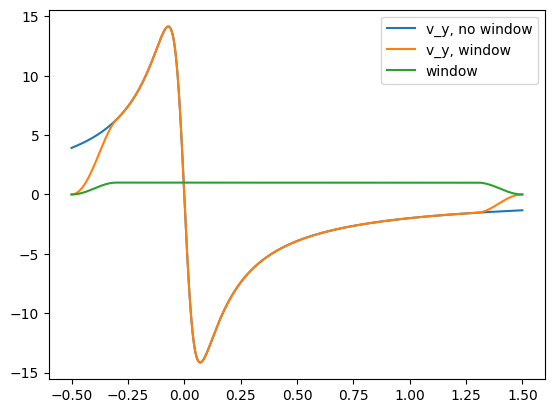

In [23]:
# z axes wave 
v_z = - v_0 * zwire * sintheta**2
# apply window function
window = signal.windows.tukey(arr_dim, 0.2)
figz, axz = plt.subplots()
axz.plot(zwire, v_z, label='v_y, no window')
v_z = v_z * window
axz.plot(zwire, v_z, label= 'v_y, window')
axz.plot(zwire, window, label='window')
axz.legend()
# Initialize coupled array
u_0 = np.zeros(2*arr_dim)
u_0[:arr_dim] = disp_0
u_0[arr_dim:] = v_z
acc_fixed = []
sol = solve_ivp(couple_fun_press, t_span= [t0, tf], y0= u_0, t_eval= t_eval, method="RK23")
t_range = range(len(sol.t))
z_celerations = np.array([accell(t, sol) for t in t_range]).transpose()

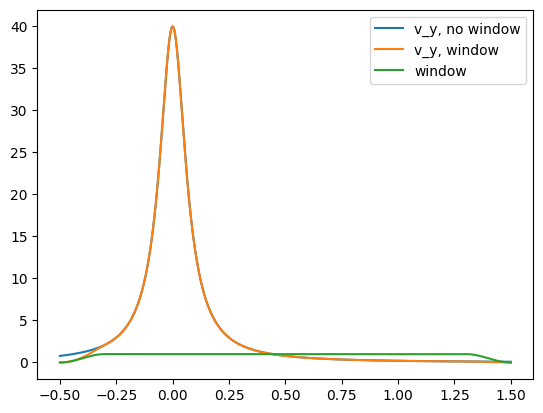

In [24]:
# y axes wave
v_y = v_0 * (b * sinphi - zwire * costheta * sintheta * cosphi)
figy, axy = plt.subplots()
axy.plot(zwire, v_y, label='v_y, no window')
v_y = v_y * window
axy.plot(zwire, v_y, label= 'v_y, window')
axy.plot(zwire, window, label='window')
axy.legend()
# Initialize coupled array
u_0 = np.zeros(2*arr_dim)
u_0[:arr_dim] = disp_0
u_0[arr_dim:] = v_y

sol = solve_ivp(couple_fun_shear, t_span= [t0, tf], y0= u_0, t_eval= t_eval, method="RK23")
y_celerations = np.array([accell(t, sol) for t in t_range]).transpose()

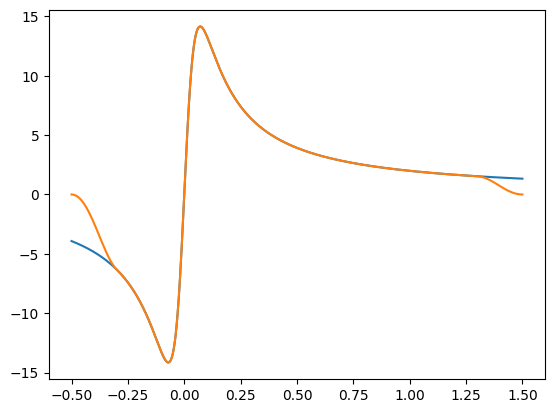

In [25]:
# x axes wave 
v_x = v_0 * (b * cosphi + zwire * costheta * sintheta * sinphi)
figx, axx = plt.subplots()
axx.plot(zwire, v_x, label='v_x, no window')
v_x = v_x * window
axx.plot(zwire, v_x, label= 'v_x, window')
axy.plot(zwire, window, label='window')
axy.legend()

# # Initialize coupled array
u_0 = np.zeros(2*arr_dim)
u_0[:arr_dim] = disp_0
u_0[arr_dim:] = v_x

sol = solve_ivp(couple_fun_shear, t_span= [t0, tf], y0= u_0, t_eval= t_eval, method="RK23")
x_celerations = np.array([accell(t, sol) for t in t_range]).transpose()

In [28]:
#Plot
z_t = arr_dim * 3//8
# graph_func(sol.t, x_celerations, y_celerations, z_celerations, z_t)

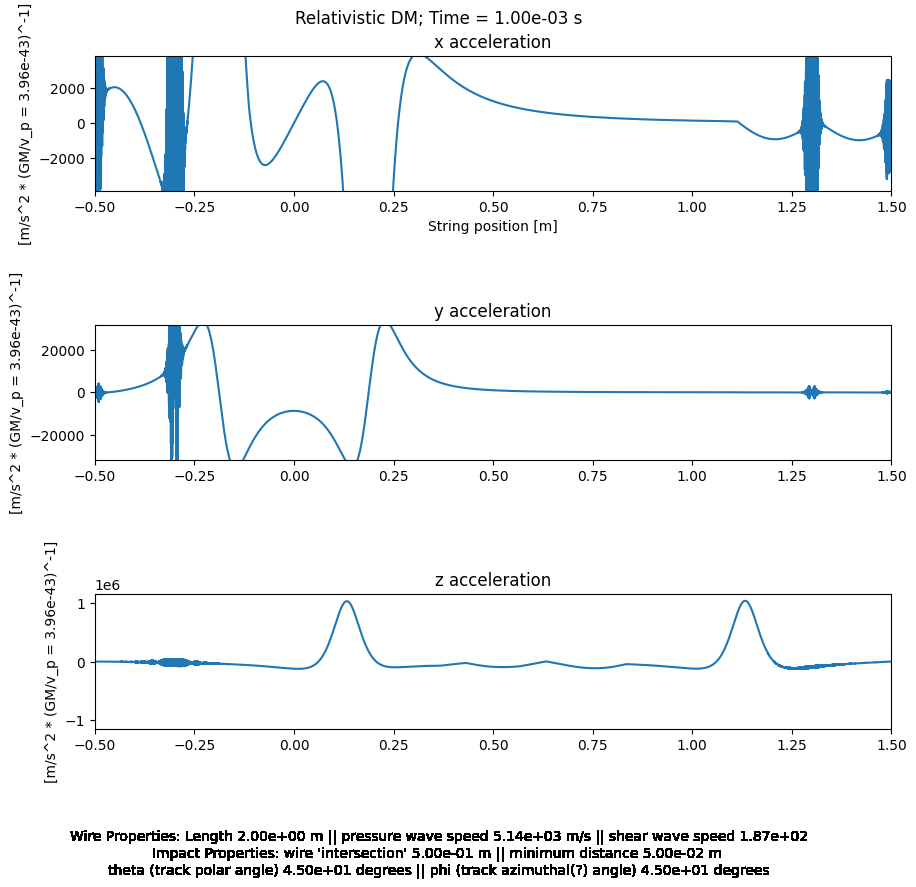

In [29]:
# animate
animate_func(t_eval, x_celerations, y_celerations, z_celerations, z_t)